In [17]:
!pip install -q -q -q geopandas
!pip install -q -q -q contextily

In this notebook, we describe the sandbox analysis of spatial distribution of buildings.

In [22]:
import numpy as np
import pandas as pd

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KDTree

Load the built-up areas

In [3]:
bocage = pd.read_csv('bocage_ign_2012.csv')
openfield = pd.read_csv('openfield_ign_2012.csv')

Display the two spatial distributions of building :

In [ ]:
s_bocage = gpd.GeoDataFrame(bocage, geometry=gpd.points_from_xy(bocage.x, bocage.y), crs='EPSG:2154')
s_openfield = gpd.GeoDataFrame(openfield, geometry=gpd.points_from_xy(openfield.x, openfield.y), crs='EPSG:2154')

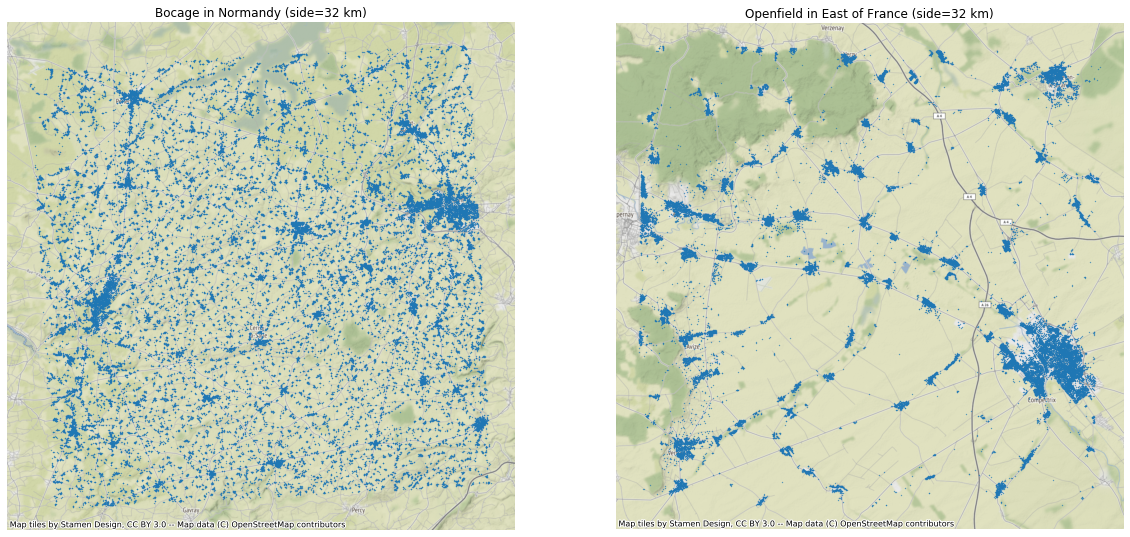

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
s_bocage.to_crs(epsg=3857).plot(ax=ax1, markersize=0.1)
ax1.axis(False)
ax1.set_title('Bocage in Normandy (side=32 km)')
ctx.add_basemap(ax1)
s_openfield.to_crs(epsg=3857).plot(ax=ax2, markersize=0.1)
ax2.axis(False)
ax2.set_title('Openfield in East of France (side=32 km)')
ctx.add_basemap(ax2)

First of all, we have to calculate the neigbhors near each building for several radius.

In [45]:
def neighbors_near_point(df, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df[['x', 'y']]) 
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True)
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(result)

In [219]:
radius_range = np.array([50, 100, 200, 400, 800, 1600, 3200])
bocage_neighbor = neighbors_near_point(bocage, radius_range)
openfield_neighbor = neighbors_near_point(openfield, radius_range)

Now, we can compute the generalized dimensions.

In [220]:
def entropy(neighbor,q):
    if q!=1:
        return(np.log2(np.sum(neighbor**(q-1)))/(q-1))
    else:
        return(np.sum(np.log2(neighbor)) /neighbor.shape[0] )

def scale_function(neighbor, list_of_q):
    resultat = []
    for q in list_of_q:
        resultat.append(entropy(neighbor, q))   
    result = pd.concat(resultat, axis=1)
    result = result.transpose()
    result['q'] = list_of_q
    return(result)

First, we calculate the generalized dimension for the scale range (radius) 50 - 800 m

In [248]:
list_of_radius = np.array([50, 100,  200, 400, 800])

In [250]:
bocage_scaling = scale_function(bocage_neighbor, np.arange(-5,5.5,0.5))
bocage_scaling['Dq'] = bocage_scaling[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log2(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] , axis=1 )  
openfield_scaling = scale_function(openfield_neighbor, np.arange(-5,5.5,0.5))
openfield_scaling['Dq'] = openfield_scaling[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log2(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] , axis=1 )  

Text(0.5, 1.0, 'Generalized Dimensions of openfield distribution [ 50 100 200 400 800]')

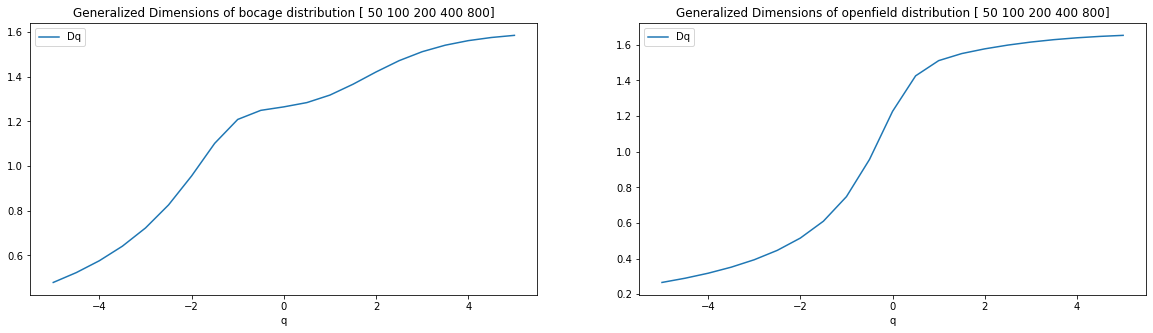

In [251]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
bocage_scaling.plot(x='q', y='Dq', ax=ax1)
ax1.set_title('Generalized Dimensions of bocage distribution ' + np.array2string(list_of_radius))
openfield_scaling.plot(x='q', y='Dq', ax=ax2)
ax2.set_title('Generalized Dimensions of openfield distribution ' + np.array2string(list_of_radius))

As we can see, on this scale range, the generalized dimensions is increasing that is inconsistent with multifractal theory. On broader scales (400 - 3200 m), we find results more in line with the theory.

In [252]:
list_of_radius = np.array([400, 800, 1600, 3200])

In [253]:
bocage_scaling = scale_function(bocage_neighbor, np.arange(-5,5.5,0.5))
bocage_scaling['Dq'] = bocage_scaling[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log2(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] , axis=1 )  
openfield_scaling = scale_function(openfield_neighbor, np.arange(-5,5.5,0.5))
openfield_scaling['Dq'] = openfield_scaling[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log2(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] , axis=1 )  

Text(0.5, 1.0, 'Generalized Dimensions of openfield distribution [ 400  800 1600 3200]')

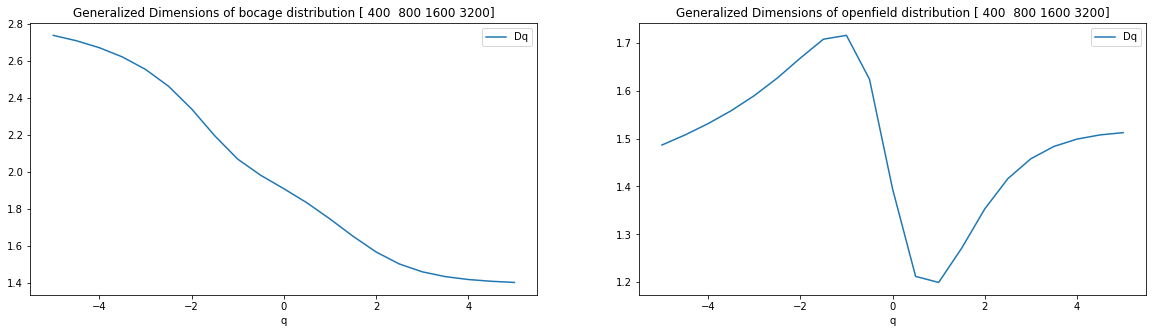

In [254]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
bocage_scaling.plot(x='q', y='Dq', ax=ax1)
ax1.set_title('Generalized Dimensions of bocage distribution ' + np.array2string(list_of_radius))
openfield_scaling.plot(x='q', y='Dq', ax=ax2)
ax2.set_title('Generalized Dimensions of openfield distribution ' + np.array2string(list_of_radius))